# Lead sets

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd

plt.rcParams.update({ "font.family": "serif", "font.serif": ["Times New Roman"], "mathtext.fontset": "cm"}) # for math symbols })

In [ ]:
data = pd.read_csv('resources/lead_set_comparison_2.csv')
# Remove the first row
data = data.iloc[1:]
data.head()

,precordial,I,I-III
1,0.930879,0.910057,0.884613
2,0.944655,0.943103,0.916564
3,0.943917,0.945086,0.931195
4,0.956131,0.953592,0.940020
5,0.960455,0.958867,0.947168


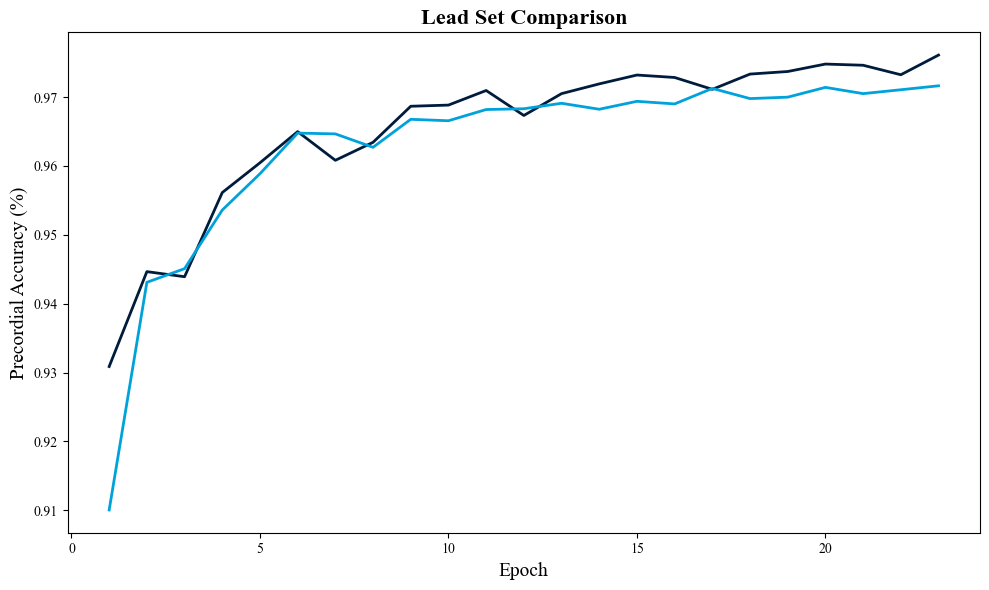

In [ ]:
# Plot as line plot
dark_blue = '#001C3D'
light_blue = '#00A2DB'
orange_red = '#E84E10'
orange = '#F39425'

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['precordial'], color=dark_blue, label='Precordial', linewidth=2)
plt.plot(data.index, data['I'], color=light_blue, label='Inferior', linewidth=2)

# Plot settings
plt.title('Lead Set Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Precordial Accuracy (%)', fontsize=14)

plt.tight_layout()
plt.show()

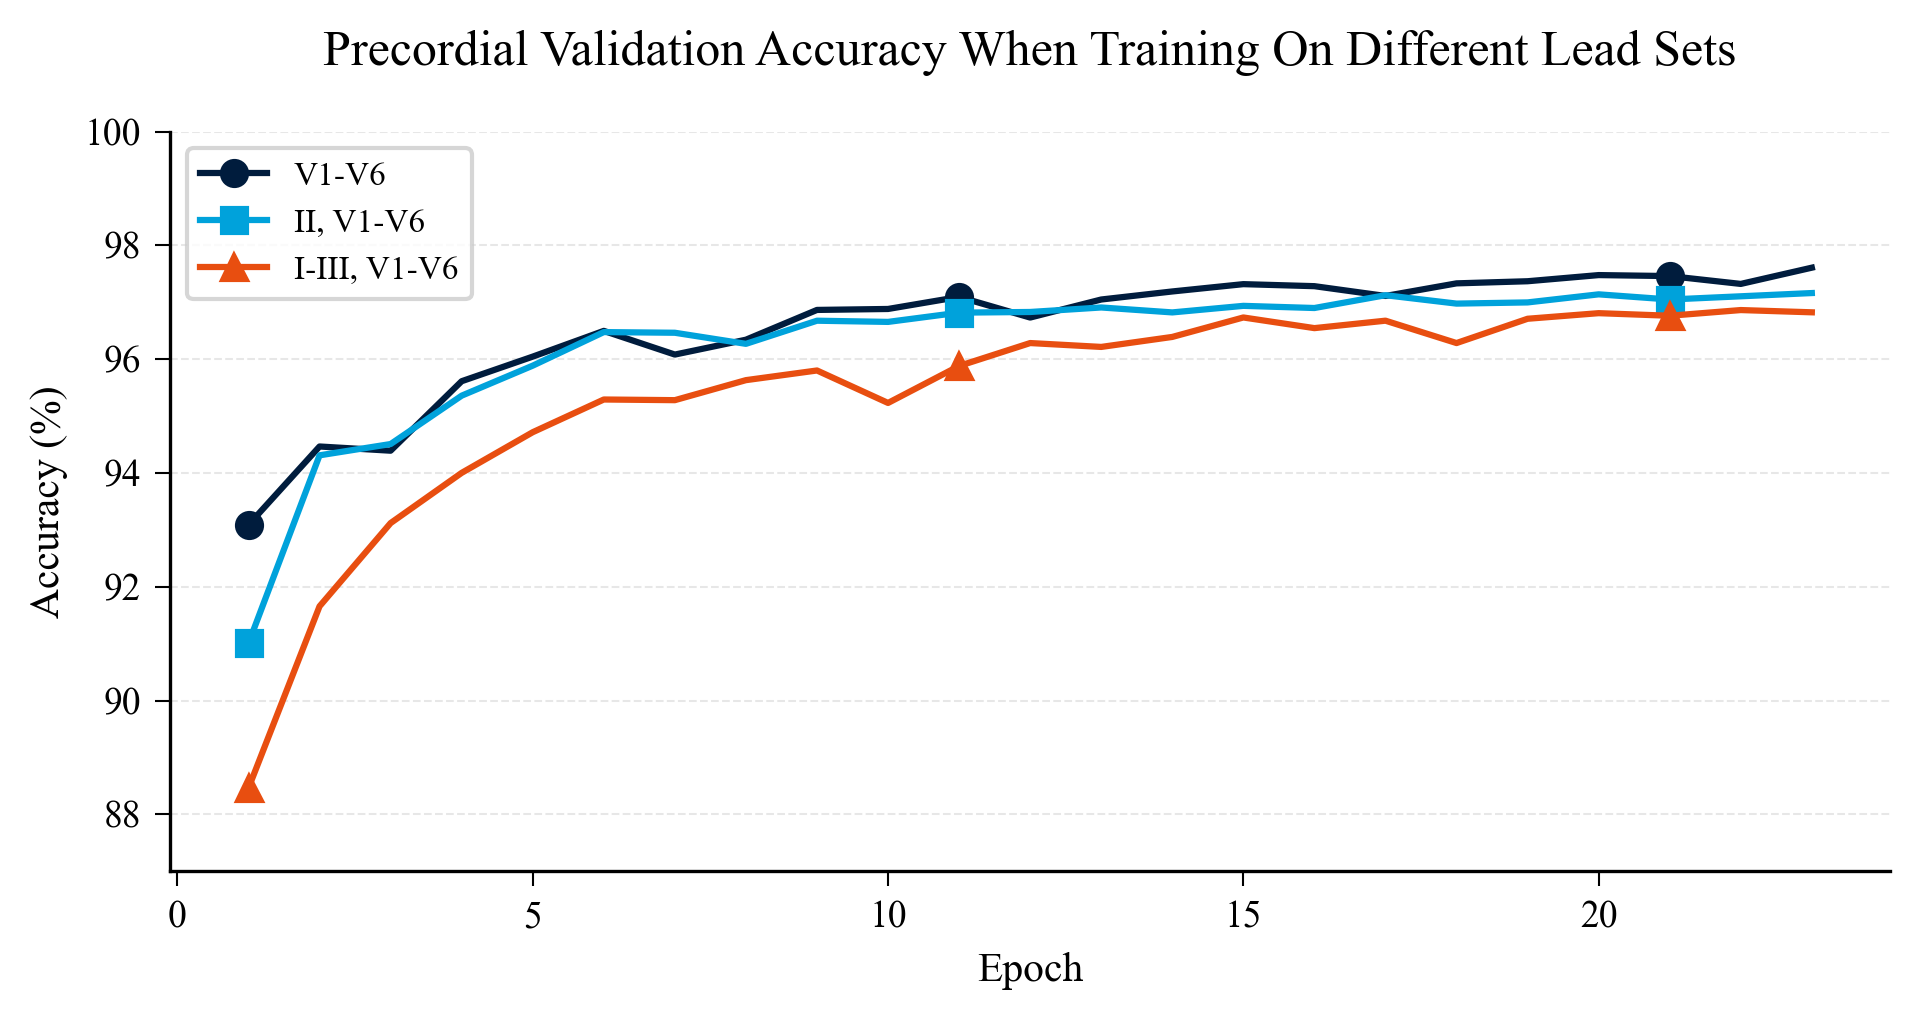

: 

In [ ]:
# ── MU colour palette ──────────────────────────────────────────────
dark_blue  = "#001C3D"   # primary
light_blue = "#00A2DB"   # accent
orange_red = "#E84E10"   # accent

# ── (demo) dummy data – remove when you have the real df ──────────
# epochs 0 … 99, two accuracy curves
# data = pd.DataFrame({
#     "precordial": np.random.normal(80, 2, 100).cumsum() / np.arange(1, 101),
#     "inferior":   np.random.normal(78, 2, 100).cumsum() / np.arange(1, 101),
# })
# data.index.name = "epoch"
# ───────────────────────────────────────────────────────────────────

# ── Global font to match previous plots ────────────────────────────
plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "CMU Bright"],  # falls back if CMU missing
    "mathtext.fontset": "cm",
})

# ── Figure ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=300)

ax.plot(data.index, data["precordial"]*100,
        label="V1-V6", color=dark_blue,  linewidth=1.5, marker="o", markevery=10)
ax.plot(data.index, data["I"]*100,
        label="II, V1-V6",   color=light_blue, linewidth=1.5, marker="s", markevery=10)
ax.plot(data.index, data["I-III"]*100,
        label="I-III, V1-V6", color=orange_red, linewidth=1.5, marker="^", markevery=10)

# Axis labels & limits
ax.set_xlabel("Epoch", fontsize=10, fontweight="regular")
ax.set_ylabel("Accuracy (%)", fontsize=10, fontweight="regular")
ax.set_ylim(87, 100)
#ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# Title
ax.set_title("Precordial Validation Accuracy When Training On Different Lead Sets",
             fontsize=12, fontweight="regular", pad=16)

# Grid & spines
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.3)
ax.spines[["top", "right"]].set_visible(False)

# Legend (outside, matching earlier style)
ax.legend(fontsize=8)
for text in ax.legend_.get_texts():
        text.set_fontname("Times New Roman")
        text.set_fontweight("regular")

# Tick styling
ax.tick_params(axis="both", labelsize=9, width=0.5)

plt.tight_layout()
plt.savefig("lead_set_comparison.pdf", bbox_inches="tight")
plt.savefig("lead_set_comparison.png", dpi=400, bbox_inches="tight")
plt.show()